In [1]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial import distance

In [2]:
pubs_author_funder = pd.read_csv("../../data/nf_folder/Data/DerivedData/CleanedRawData/pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(
    lambda x:literal_eval(x) if pd.notnull(x) else "Not-Funded")
#pubs_author_funder['funding_units'] = pubs_author_funder['funder_country'].apply(lambda x: len(x))
pubs_author_funder.head()

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,author_country,funder_country,discipline,year,rel_citation,citation
0,30507292,[Turkey],[Turkey],77,2009,0.485,6
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9
2,30574691,[Russia],[Russia],83,2009,0.312,4
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3


In [3]:
pubs_author_funder['author_distinct']=pubs_author_funder['author_country'].apply(lambda x:list(set(x)))
pubs_author_funder['funder_distinct']=pubs_author_funder['funder_country'].apply(
    lambda x:list(set(x)) if x!='Not-Funded' else 'Not-Funded')


In [4]:
pubs_author_funder.head()

,id,author_country,funder_country,discipline,year,rel_citation,citation,author_distinct,funder_distinct
0,30507292,[Turkey],[Turkey],77,2009,0.485,6,[Turkey],[Turkey]
1,30574690,"[United States, France]","[United States, United States, United States, ...",83,2009,0.703,9,"[France, United States]",[United States]
2,30574691,[Russia],[Russia],83,2009,0.312,4,[Russia],[Russia]
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",89,2009,0.137,1,[Spain],[Spain]
4,30585097,"[Germany, Spain]",[Spain],89,2009,0.410,3,"[Spain, Germany]",[Spain]


In [5]:
pubs_author_funder['IntCol']=pubs_author_funder['author_distinct'].apply(
    lambda x: 'col' if len(x)>1 else 'notcol')

In [6]:
cntry_pub=pubs_author_funder[['author_distinct','funder_distinct','year','IntCol']
                            ].explode('author_distinct')
cntry_pub.head()

,author_distinct,funder_distinct,year,IntCol
0,Turkey,[Turkey],2009,notcol
1,France,[United States],2009,col
1,United States,[United States],2009,col
2,Russia,[Russia],2009,notcol
3,Spain,[Spain],2009,notcol


In [7]:
def check_fund(x):
    label = 'notfund'
    if x.author_distinct in x.funder_distinct:
        label = 'fund'
    return label
cntry_pub['fund'] = cntry_pub.apply(lambda x:check_fund(x),axis=1)
cntry_pub.head()

,author_distinct,funder_distinct,year,IntCol,fund
0,Turkey,[Turkey],2009,notcol,fund
1,France,[United States],2009,col,notfund
1,United States,[United States],2009,col,fund
2,Russia,[Russia],2009,notcol,fund
3,Spain,[Spain],2009,notcol,fund


In [8]:
cntry_pub.year.unique()

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [14]:
cntry_col=cntry_pub[cntry_pub.year==2018].groupby(['author_distinct','IntCol']).size().reset_index(name='count')
cntry_col=cntry_col.pivot_table(index='author_distinct',columns='IntCol',values='count')
cntry_col=cntry_col.div(cntry_col.sum(axis=1), axis=0).reset_index()
cntry_col.head()

IntCol,author_distinct,col,notcol
0,Afghanistan,0.938462,0.061538
1,Albania,0.903553,0.096447
2,Algeria,0.604925,0.395075
3,Andorra,1.000000,NaN
4,Angola,0.983607,0.016393


In [15]:
cntry_col_fund=cntry_pub[(cntry_pub.IntCol=='col')&(cntry_pub.year==2018)].groupby(['author_distinct','fund']).size().reset_index(name='count')
cntry_col_fund=cntry_col_fund.pivot_table(index='author_distinct',columns='fund',values='count')
cntry_col_fund=cntry_col_fund.div(cntry_col_fund.sum(axis=1), axis=0).reset_index()
cntry_col_fund.head()

fund,author_distinct,fund,notfund
0,Afghanistan,NaN,1.000000
1,Albania,NaN,1.000000
2,Algeria,0.090708,0.909292
3,Andorra,0.250000,0.750000
4,Angola,0.083333,0.916667


In [16]:
cntry_cnt=cntry_pub[cntry_pub.year==2018].groupby('author_distinct').size().reset_index(name='count')
cntry_cnt['count']=np.log10(cntry_cnt['count'])

In [17]:
cntry_meta=cntry_col[['author_distinct','col']].merge(
    cntry_col_fund[['author_distinct','fund']],on='author_distinct',how='inner')
cntry_meta=cntry_meta.merge(cntry_cnt,on='author_distinct',how='inner')
cntry_meta.head()

,author_distinct,col,fund,count
0,Afghanistan,0.938462,NaN,1.812913
1,Albania,0.903553,NaN,2.294466
2,Algeria,0.604925,0.090708,3.572407
3,Andorra,1.000000,0.250000,1.079181
4,Angola,0.983607,0.083333,1.785330


In [13]:
meta_early=cntry_meta
meta_early=meta_early.rename(columns={'col':'col_2009','fund':'fund_2009','count':'count_2009'})

In [18]:
meta_recent=cntry_meta
meta_recent=meta_recent.rename(columns={'col':'col_2018','fund':'fund_2018','count':'count_2018'})

In [19]:
meta_comp=meta_recent.merge(meta_early, on='author_distinct')
meta_comp=meta_comp.dropna()
meta_comp.head()

,author_distinct,col_2018,fund_2018,count_2018,col_2009,fund_2009,count_2009
2,Algeria,0.604925,0.090708,3.572407,0.612863,0.045267,3.200303
6,Argentina,0.516570,0.432533,3.970997,0.448504,0.380825,3.822887
7,Armenia,0.741282,0.317147,2.948902,0.536145,0.093633,2.697229
8,Australia,0.662600,0.349140,4.755631,0.481903,0.297128,4.488240
9,Austria,0.751194,0.306128,4.196093,0.607832,0.224662,4.004880


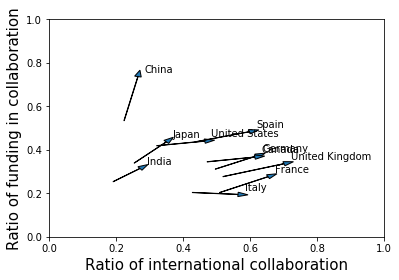

In [32]:
fig, ax=plt.subplots()
for ind, row in meta_comp.sort_values(by='count_2009',ascending=False).head(10).iterrows():
    x=row['col_2009']
    y=row['fund_2009']
    dx=row['col_2018']
    dy=row['fund_2018']
    cntry=row['author_distinct']
    plt.arrow(x,y,(dx-x),(dy-y),head_width=0.02)
    plt.text(dx+0.02,dy+0.02,cntry)
plt.xlabel("Ratio of international collaboration",fontsize=15)
plt.ylabel("Ratio of funding in collaboration",fontsize=15)
plt.savefig("funding_ratio_collaboration.pdf",bbox_inches="tight")

In [27]:
meta_comp.sort_values(by='count_2009',ascending=False).head(10)

,author_distinct,col_2018,fund_2018,count_2018,col_2009,fund_2009,count_2009
183,United States,0.464636,0.440059,5.547100,0.321063,0.418821,5.449631
37,China,0.265053,0.736844,5.588026,0.223630,0.533996,5.087760
66,Germany,0.618416,0.371337,5.014798,0.496058,0.311260,4.903925
88,Japan,0.349773,0.436387,4.900274,0.253929,0.339146,4.873652
182,United Kingdom,0.701066,0.336079,5.021673,0.518897,0.276696,4.870673
60,France,0.653525,0.276379,4.851527,0.508941,0.203303,4.775334
85,Italy,0.563897,0.194975,4.826878,0.427486,0.203779,4.682650
32,Canada,0.614118,0.366661,4.794913,0.471687,0.344872,4.662125
160,Spain,0.597677,0.483175,4.739129,0.434201,0.436021,4.589089
79,India,0.270998,0.314241,4.852028,0.190892,0.253496,4.586385


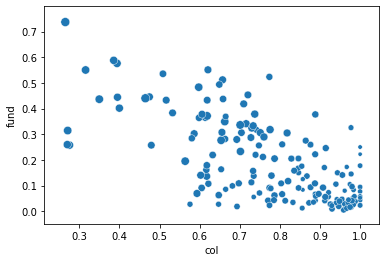

In [51]:
sns.scatterplot(x='col',y='fund',data=cntry_meta,size='count',sizes=(5,80),legend=False)

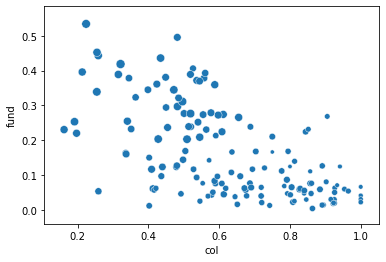

In [44]:
sns.scatterplot(x='col',y='fund',data=cntry_meta,size='count',sizes=(5,80),legend=False)

In [8]:
(np.exp(12.8669)-np.exp(12.7129))/np.exp(12.7129)

0.16649088677843943

In [5]:
np.exp(12.7129)

332003.23771344335

In [10]:
0.181*np.log(1.10)

0.017251142544582817